In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


### Load A Dataset

In [7]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Data Cleaning

In [8]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop missing values
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

# Drop customerID (not useful for prediction)
df.drop(columns=['customerID'], inplace=True, errors='ignore')

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Replace "No internet service"/"No phone service" with "No"
cols_with_no_services = [
    'OnlineSecurity','OnlineBackup','DeviceProtection',
    'TechSupport','StreamingTV','StreamingMovies','MultipleLines'
]
for c in cols_with_no_services:
    if c in df.columns:
        df[c] = df[c].replace({'No internet service': 'No', 'No phone service': 'No'})

df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


### EDA

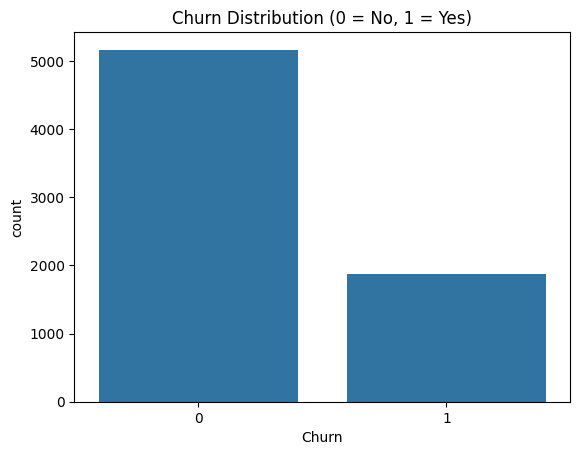

Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution (0 = No, 1 = Yes)")
plt.show()

print(df["Churn"].value_counts(normalize=True))


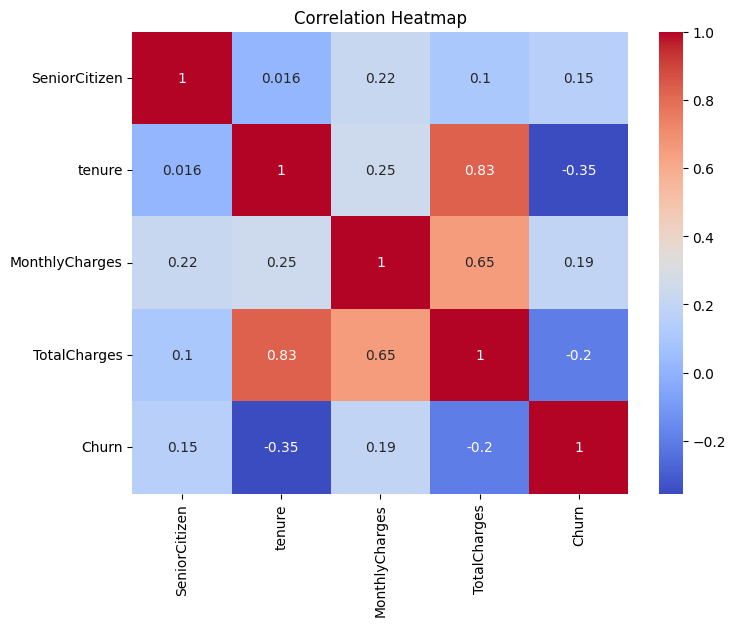

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


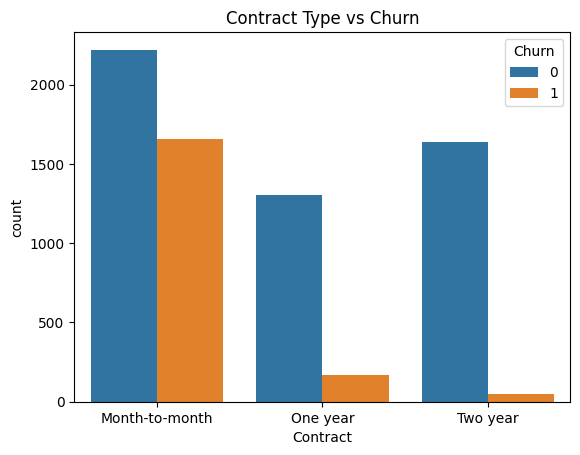

In [11]:
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Contract Type vs Churn")
plt.show()


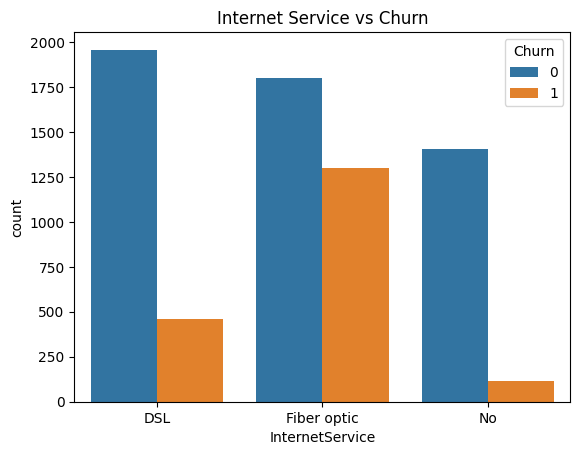

In [12]:
sns.countplot(x="InternetService", hue="Churn", data=df)
plt.title("Internet Service vs Churn")
plt.show()


### Preprocessing & Train-Test split

In [13]:
X = df.drop('Churn', axis=1)   # Features
y = df['Churn']                # Target


In [14]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [c for c in X.columns if c not in numeric_features]


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
])


### Model Training

In [19]:
#Define models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(n_estimators=200, random_state=42, eval_metric='logloss')
}


In [20]:
#Train and compare
best_model = None
best_recall = 0
best_pipe = None

for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('clf', clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:,1]

    print("="*30, name, "="*30)
    print(classification_report(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, probs))

    # focus on recall (important in churn)
    report = classification_report(y_test, preds, output_dict=True)
    recall = report['1']['recall']
    if recall > best_recall:
        best_recall = recall
        best_model = name
        best_pipe = pipe

print(f"\n✅ Best model: {best_model} with Recall={best_recall:.2f}")


============================== LogisticRegression ==============================
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.74      1407

ROC AUC: 0.8352871290204017
============================== RandomForest ==============================
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407

ROC AUC: 0.8150705851292378
============================== XGBoost ==============================
              precision    recall  f1-score   support

         

### Model Evaluation

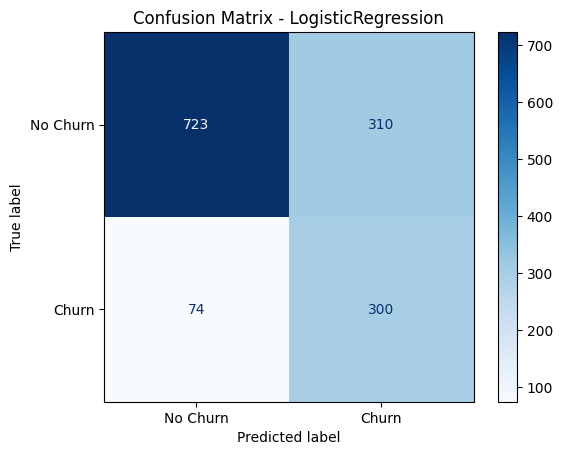

In [21]:
#Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = best_pipe.predict(X_test)
cm = confusion_matrix(y_test, preds)

disp = ConfusionMatrixDisplay(cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_model}")
plt.show()


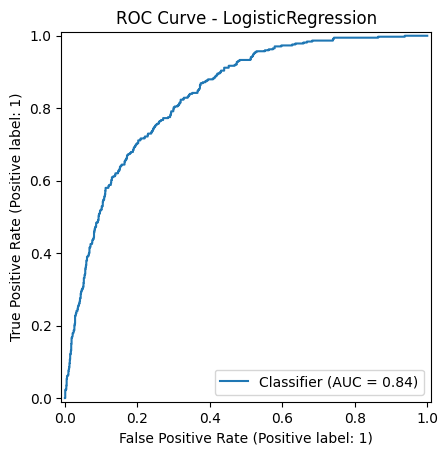

In [22]:
#ROC Curve
from sklearn.metrics import RocCurveDisplay

probs = best_pipe.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, probs)
plt.title(f"ROC Curve - {best_model}")
plt.show()


In [23]:
#Saving the model
import joblib

feature_columns = X.columns.tolist()
defaults = {}
for c in X.columns:
    if X[c].dtype == 'object':
        defaults[c] = X[c].mode()[0]
    else:
        defaults[c] = X[c].median()

joblib.dump(
    {'pipeline': best_pipe, 'feature_columns': feature_columns, 'defaults': defaults},
    "churn_bundle.pkl"
)

print("✅ Model saved as churn_bundle.pkl")


✅ Model saved as churn_bundle.pkl
